# Create ROC
This notebook creates the ROC curve (Figure 5).

Requires the CAD model output from `run_CAD_on_data.ipynb`, also available as `*_results.csv` files within each dataset directory.

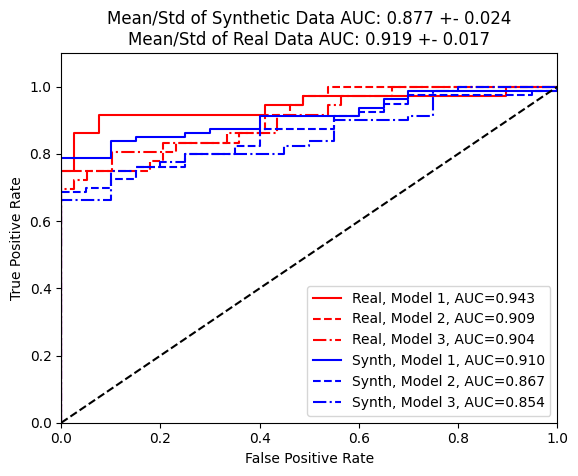

In [ ]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

# read in Hssayeni results
df = pd.read_csv('../datasets/real_dataset_predictions.csv')

#dataset_path = Path('../datasets')
# dataset_path = '/projects01/didsr-aiml/jayse.weaver/insilicoich/'
# dataset_name = 'manuscript_100_280mA_wME'
study_name = os.getenv('STUDY_NAME')
base_dir = Path(os.getenv('BASE_DIR')) / study_name
model_names = ['CAD_1', 'CAD_2', 'CAD_3']
colors = ['blue', 'blue', 'blue'] #, 'blue', 'green', 'c']
styles = ['-', '--', '-.'] #, '-.', '-.']

synth_auc = []
real_auc = []

for idx, model in enumerate(model_names):

    # read in real results
    df_real = pd.read_csv('../datasets/' + model + '_real_preds.csv')
    results_real = df_real[["Any_ICH", "Model_Output"]].to_numpy()
    results_real = results_real[~np.isnan(results_real).any(axis=1), :] # remove rows with nan (no CT images)
    labels_real = results_real[:, 0]
    pred_real = results_real[:, 1]
    fpr_real, tpr_real, thresholds_real = metrics.roc_curve(labels_real, pred_real, pos_label=1)
    roc_df_real = pd.DataFrame(zip(fpr_real, tpr_real, thresholds_real),columns = ["FPR","TPR","Threshold"])
    real_auc.append(metrics.auc(fpr_real, tpr_real))

    plt.plot(fpr_real, tpr_real, styles[idx], label = ('Real, Model ' + str(idx+1) + ', AUC=%0.3f' % real_auc[idx]), color='red', markersize=0)

for idx, model in enumerate(model_names):

    # read in synthetic results
    ds1 = pd.read_csv(str(base_dir / study_name) + '_' + model + '_results.csv')
    fpr, tpr, thresh = metrics.roc_curve(ds1['TruthLabel'], ds1['ModelPrediction'], pos_label=1)
    synth_auc.append(metrics.auc(fpr, tpr))

    plt.plot(fpr, tpr, styles[idx], label = ('Synth, Model ' + str(idx+1) + ', AUC=%0.3f' % synth_auc[idx]), color='blue', markersize=0)

plt.title('Mean/Std of Synthetic Data AUC: %0.3f +- %0.3f\nMean/Std of Real Data AUC: %0.3f +- %0.3f' % (np.mean(synth_auc) , np.std(synth_auc) , np.mean(real_auc) , np.std(real_auc)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='black')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig('manuscript_figures/Figure7.png', format='png', dpi=600)
